# Revision of 2021 Multiple Strategic Agent Codes

James Yu, 12 November 2022

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

This is an extremely basic adjustment of the 2021 notebook [Benchmarks with Dual Message (asymmetric case)](https://github.com/weiliubc/strategic_influencer_of_naive_agents/blob/main/multiple_strategic_agents/benchmarks_dual_message_asymmetric.pdf) to use the Unified Model version of the multiple strategic agents case. A lot of the code style uses past approaches which should be updated with faster and neater versions in the future. Despite this, the results should still be the same.

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def do_plot(rs, r, payoffs, num_agents = 1, set_cap = np.inf, flag = False, legend = True):
    fig, sub = plt.subplots(2, sharex=True)
    if legend:
        fig.suptitle(f"Terminal Strategy: {', '.join(['$r_{ss}^' + str(l+1) + '$ = ' + str(round(rs[l][:min(len(rs[l]), set_cap)][-1].item() + r[l], 2)) for l in range(num_agents)])}")

    for l in range(num_agents):
        sub[0].plot(range(min(len(rs[l]), set_cap)), [a.item() + r[l] for a in rs[l][:min(len(rs[l]), set_cap)]], label = f"Optimal: {['Agent', 'Channel'][flag]} {l+1}")
    sub[0].set(ylabel = "r_t message")

    for l in range(num_agents):
        sub[1].plot(range(min(len(payoffs[l]), set_cap)), payoffs[l][:min(len(payoffs[l]), set_cap)], label = f"Optimal: {['Agent', 'Channel'][flag]} {l+1}")
    sub[1].set(xlabel = "Time", ylabel =  "Cumulative Payoff")
    if legend:
        sub[0].legend()
        sub[1].legend()
    plt.show()

In [7]:
# taken from higher_cost_version.ipynb
# we would expect the results on these matrices to be the same as existing results
A_alt = np.array([ # balanced
    [0.48, 0.3, 0.22],
    [0.3, 0.52, 0.18],
    [0.22, 0.18, 0.6]
])

A = np.array([ # stubborn
    [0.9, 0.07, 0.03],
    [0.07, 0.58, 0.35],
    [0.03, 0.35, 0.62]
])

A_identical = np.array([ # identical
    [0.6, 0.2, 0.2],
    [0.2, 0.6, 0.2],
    [0.2, 0.2, 0.6]
])

X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
X_0 = [X_0_1, X_0_1] # SAME AGENDA = 0 FOR NOW

delta = 0.9 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [200 * np.identity(n), 200 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting
x = [0, 0] # identical agendas
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
c # we expect this to be zero if the agendas are zero given that r = 0 holds now

[array([[0.],
        [0.],
        [0.]]),
 array([[0.],
        [0.],
        [0.]])]

In [8]:
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)

In [9]:
historical_K[0]

[array([[3.78777267, 1.14352889, 1.03448866],
        [1.14352889, 2.91545084, 1.90681049],
        [1.03448866, 1.90681049, 3.02449107]]),
 array([[3.78777267, 1.14352889, 1.03448866],
        [1.14352889, 2.91545084, 1.90681049],
        [1.03448866, 1.90681049, 3.02449107]])]

In [10]:
xs2, rs2, payoffs2 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
#do_plot(rs2, r, payoffs2, num_agents = 2, set_cap = 20)

A first test: this should yield the same plot as in [Unified Model with Multiple Strategic Agents](https://github.com/weiliubc/strategic_influencer_of_naive_agents/blob/main/unified_model/multiple_unified_symmetric.ipynb).

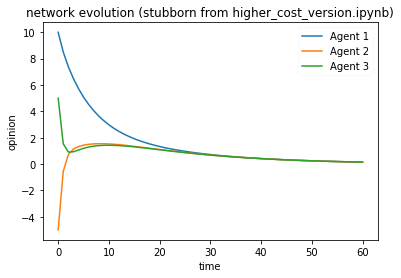

In [11]:
for i in range(3):
    plt.plot(range(60+1), [xs2[0][j][i].item() for j in range(60+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution (stubborn from higher_cost_version.ipynb)")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

This is indeed the same plot.

The above setup used 2 agents with the same agenda; next, we test different agendas:

In [12]:
a = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
a

array([[10.],
       [-5.],
       [ 5.]])

In [13]:
a - 5

array([[  5.],
       [-10.],
       [  0.]])

In [14]:
A = np.array([ # stubborn
    [0.9, 0.07, 0.03],
    [0.07, 0.58, 0.35],
    [0.03, 0.35, 0.62]
])

b = 5 # a different agenda for strategic agent 2

X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
# recall \chi = \overline{x} - x_l 1_n
X_0 = [X_0_1, X_0_1 - b]

delta = 0.9 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [200 * np.identity(n), 200 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [0, b] # NOW WITH DIFFERENT AGENDAS
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
c # because the rows of A sum up to 1, A - I has rows that sum up to zero, so any constant combination of a row's entries will be zero too

[array([[0.],
        [0.],
        [0.]]),
 array([[1.66533454e-16],
        [0.00000000e+00],
        [0.00000000e+00]])]

In [15]:
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)

In [16]:
xs3, rs3, payoffs3 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

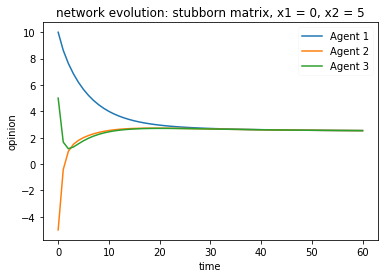

In [17]:
for i in range(3):
    plt.plot(range(60+1), [xs3[0][j][i].item() for j in range(60+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: stubborn matrix, x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

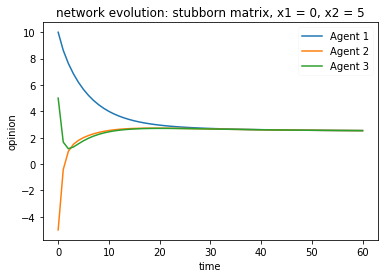

In [18]:
# test that the opinions associated with agent 2 are shifted from those of agent 1 by b = 5
for i in range(3):
    plt.plot(range(60+1), [xs3[1][j][i].item() + b for j in range(60+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: stubborn matrix, x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

Indeed these two plots are the same, and not the same as the equal agendas case; instead, the limit opinions fall somewhere in the middle:

In [19]:
xs3[0][-1]

array([[2.5],
       [2.5],
       [2.5]])

In fact, exactly in the middle of 0 and 5: we get $x^*_j = b/2$ just like in the note.

The messages here might be of note:

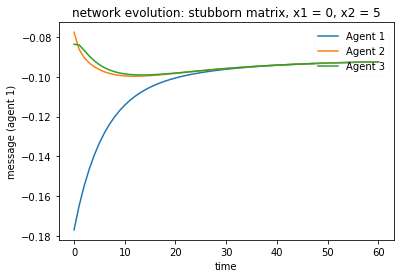

In [20]:
for i in range(3):
    plt.plot(range(60+1), [rs3[0][j][i].item() for j in range(60+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 1)")
plt.title("network evolution: stubborn matrix, x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

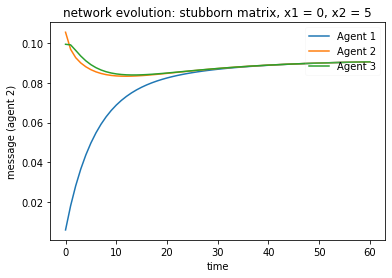

In [21]:
for i in range(3):
    plt.plot(range(60+1), [rs3[1][j][i].item() for j in range(60+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 2)")
plt.title("network evolution: stubborn matrix, x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

We can try this for a different setup:

In [22]:
A =  np.array([ # balanced
    [0.48, 0.3, 0.22],
    [0.3, 0.52, 0.18],
    [0.22, 0.18, 0.6]
])

b = -73 # a different agenda for strategic agent 2

X_0_1 = np.array([[-27.0, 63.0, -78.0]], ndmin = 2).T
# recall \chi = \overline{x} - x_l 1_n
X_0 = [X_0_1, X_0_1 - b]

delta = 0.5 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [10 * np.identity(n), 10 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [0, b] # NOW WITH DIFFERENT AGENDAS
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs4, rs4, payoffs4 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

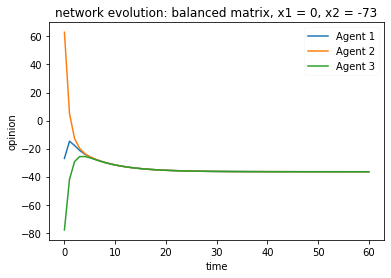

In [23]:
for i in range(3):
    plt.plot(range(60+1), [xs4[0][j][i].item() for j in range(60+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: balanced matrix, x1 = 0, x2 = -73")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

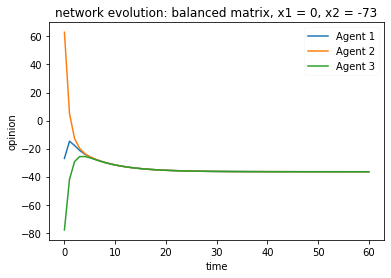

In [24]:
for i in range(3):
    plt.plot(range(60+1), [xs4[1][j][i].item() + b for j in range(60+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: balanced matrix, x1 = 0, x2 = -73")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

In [25]:
b/2

-36.5

In [26]:
xs4[0][-1]

array([[-36.5],
       [-36.5],
       [-36.5]])

Again, the result holds.

A quick test of how opinion convergence evolves - this will be useful for comparison later:

In [27]:
A =  np.array([ # balanced
    [0.48, 0.3, 0.22],
    [0.3, 0.52, 0.18],
    [0.22, 0.18, 0.6]
])

b = 5 # a different agenda for strategic agent 2

X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
# recall \chi = \overline{x} - x_l 1_n
X_0 = [X_0_1, X_0_1 - b]

delta = 0.5 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [200 * np.identity(n), 200 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [0, b] # NOW WITH DIFFERENT AGENDAS
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs4a, rs4a, payoffs4a = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

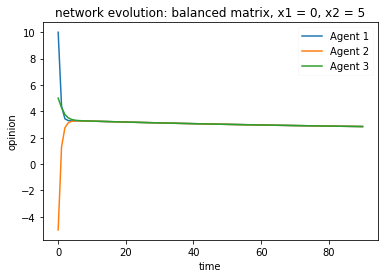

In [28]:
for i in range(3):
    plt.plot(range(90+1), [xs4a[0][j][i].item() for j in range(90+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: balanced matrix, x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

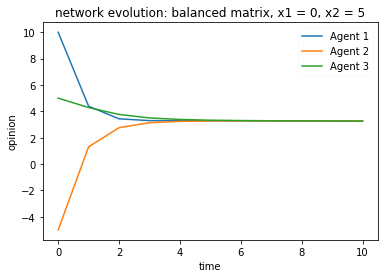

In [29]:
for i in range(3):
    plt.plot(range(10+1), [xs4a[0][j][i].item() for j in range(10+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: balanced matrix, x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

In [30]:
xs4a[0][30] # T = 30 or so

array([[3.12091619],
       [3.12091619],
       [3.12091619]])

In [31]:
xs4a[0][-1]

array([[2.5],
       [2.5],
       [2.5]])

This means that the opinions first converge to mutual equality before converging to the agenda (actually, this also happens in the very first plot).

Now we can explore what would happen if we had asymmetry in the network but symmetry in the agendas. This is new territory.

In [32]:
A = np.array([ # asymmetric
    [0.6, 0.3, 0.1],
    [0.4, 0.1, 0.5],
    [0.5, 0.2, 0.3]
])

X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
X_0 = [X_0_1, X_0_1]

delta = 0.9 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [200 * np.identity(n), 200 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [0, 0]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs5, rs5, payoffs5 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

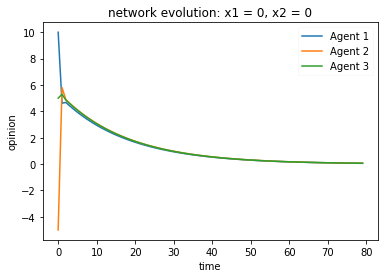

In [33]:
for i in range(3):
    plt.plot(range(80), [xs5[0][j][i].item() for j in range(80)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = 0, x2 = 0")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

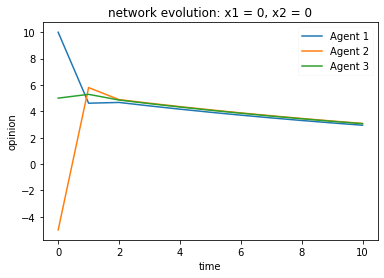

In [34]:
for i in range(3):
    plt.plot(range(10+1), [xs5[0][j][i].item() for j in range(10+1)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = 0, x2 = 0")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

In [35]:
xs5[0][-1]

array([[5.e-323],
       [5.e-323],
       [5.e-323]])

The limit opinions are zero (the above is $5 \cdot 10^{-323}$ in scientific notation). It takes a short period of time for the opinions to converge to each other but a long period of time for them to converge to the agenda. The same behaviour appears in the balanced symmetric matrix case above.

The next question is what do the messages look like:

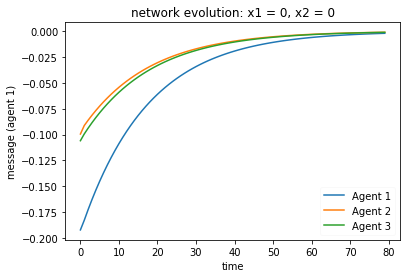

In [36]:
for i in range(3):
    plt.plot(range(80), [rs5[0][j][i].item() for j in range(80)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 1)")
plt.title("network evolution: x1 = 0, x2 = 0")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

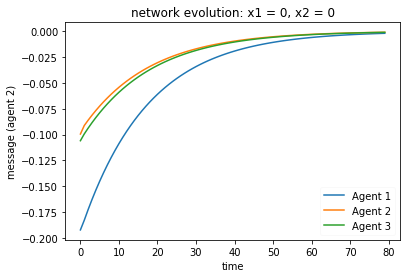

In [37]:
for i in range(3):
    plt.plot(range(80), [rs5[1][j][i].item() for j in range(80)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 2)")
plt.title("network evolution: x1 = 0, x2 = 0")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

Finally, we can look at the payoffs:

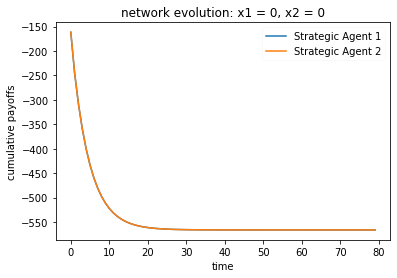

In [38]:
plt.plot(range(80), [payoffs5[0][j] for j in range(80)], label = f"Strategic Agent 1")
plt.plot(range(80), [payoffs5[1][j] for j in range(80)], label = f"Strategic Agent 2")
    
plt.xlabel("time")
plt.ylabel("cumulative payoffs")
plt.title("network evolution: x1 = 0, x2 = 0")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

We had a high message cost in the above network, which based on previous results might have contributed to the long convergence time. If we reduce it:

In [39]:
A = np.array([ # asymmetric
    [0.6, 0.3, 0.1],
    [0.4, 0.1, 0.5],
    [0.5, 0.2, 0.3]
])

X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
X_0 = [X_0_1, X_0_1]

delta = 0.9 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [1 * np.identity(n), 1 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [0, 0]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs6, rs6, payoffs6 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

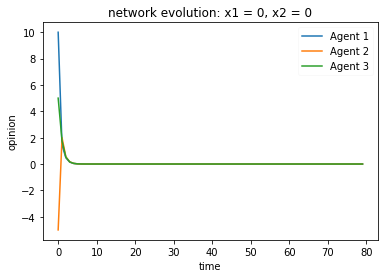

In [40]:
for i in range(3):
    plt.plot(range(80), [xs6[0][j][i].item() for j in range(80)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = 0, x2 = 0")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

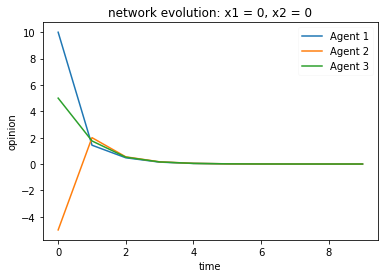

In [41]:
for i in range(3):
    plt.plot(range(10), [xs6[0][j][i].item() for j in range(10)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = 0, x2 = 0")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

Then this converges much faster, though we still have the same behaviour of converging to mutual equality first, followed by convergence to agenda.

Now we can look at different agendas. This is new territory and assumes no typos in the expressions for the lower-order matrix terms in the recursive equations.

In [42]:
A = np.array([ # asymmetric
    [0.6, 0.3, 0.1],
    [0.4, 0.1, 0.5],
    [0.5, 0.2, 0.3]
])

b = 5
X_0_1 = np.array([[10.0, -5.0, 5.0]], ndmin = 2).T
X_0 = [X_0_1, X_0_1 - 5]

delta = 0.9 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [1 * np.identity(n), 1 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [0, b]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs7, rs7, payoffs7 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

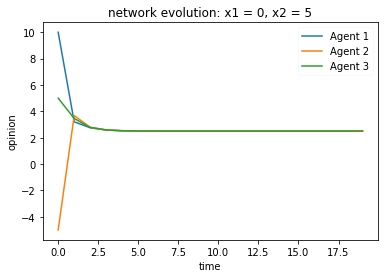

In [43]:
for i in range(3):
    plt.plot(range(20), [xs7[0][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

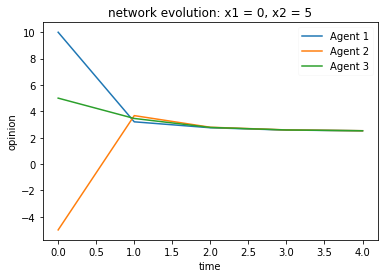

In [44]:
for i in range(3):
    plt.plot(range(5), [xs7[0][j][i].item() for j in range(5)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

In [45]:
xs7[0][-1]

array([[2.5],
       [2.5],
       [2.5]])

This is, again, $b/2$.

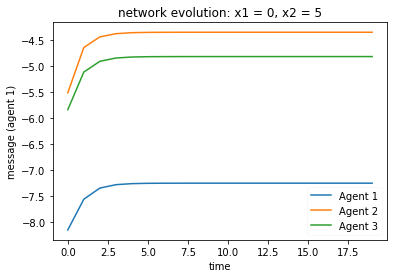

In [46]:
for i in range(3):
    plt.plot(range(20), [rs7[0][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 1)")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

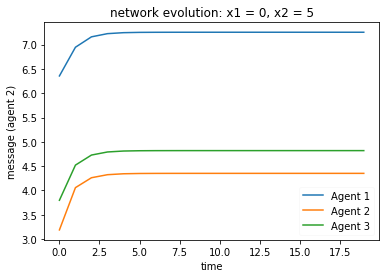

In [47]:
for i in range(3):
    plt.plot(range(20), [rs7[1][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 2)")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

And the payoffs:

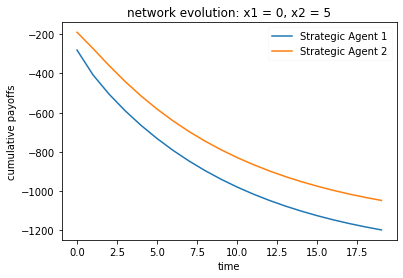

In [48]:
plt.plot(range(20), [payoffs7[0][j] for j in range(20)], label = f"Strategic Agent 1")
plt.plot(range(20), [payoffs7[1][j] for j in range(20)], label = f"Strategic Agent 2")
    
plt.xlabel("time")
plt.ylabel("cumulative payoffs")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

Test: what if the initial opinions are further away from strategic agent 2:

In [49]:
A = np.array([ # asymmetric
    [0.6, 0.3, 0.1],
    [0.4, 0.1, 0.5],
    [0.5, 0.2, 0.3]
])

b = 5
X_0_1 = np.array([[-10.0, -5.0, -5.0]], ndmin = 2).T
X_0 = [X_0_1, X_0_1 - 5]

delta = 0.9 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [1 * np.identity(n), 1 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [0, b]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs8, rs8, payoffs8 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

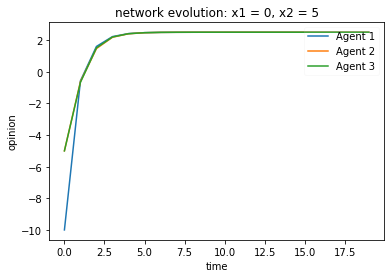

In [50]:
for i in range(3):
    plt.plot(range(20), [xs8[0][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

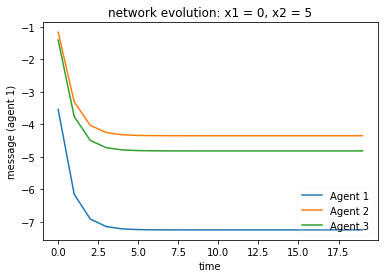

In [51]:
for i in range(3):
    plt.plot(range(20), [rs8[0][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 1)")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

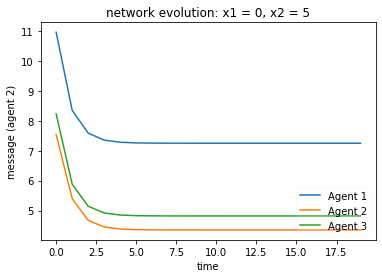

In [52]:
for i in range(3):
    plt.plot(range(20), [rs8[1][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 2)")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

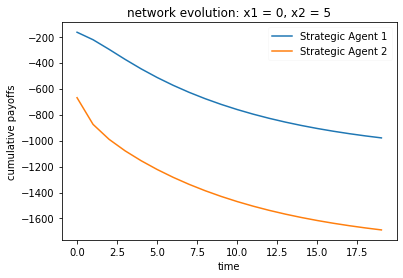

In [53]:
plt.plot(range(20), [payoffs8[0][j] for j in range(20)], label = f"Strategic Agent 1")
plt.plot(range(20), [payoffs8[1][j] for j in range(20)], label = f"Strategic Agent 2")
    
plt.xlabel("time")
plt.ylabel("cumulative payoffs")
plt.title("network evolution: x1 = 0, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

The adjustment of the initial opinions indeed causes a payoff reversal.

We can look at what would happen if the agendas were opposite:

In [54]:
A = np.array([ # asymmetric
    [0.6, 0.3, 0.1],
    [0.4, 0.1, 0.5],
    [0.5, 0.2, 0.3]
])

X_0_1 = np.array([[-10.0, 5.0, 5.0]], ndmin = 2).T
X_0 = [X_0_1 + 5, X_0_1 - 5]

delta = 0.9 # discount rate
n = 3 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [1 * np.identity(n), 1 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [-5, 5]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs9, rs9, payoffs9 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

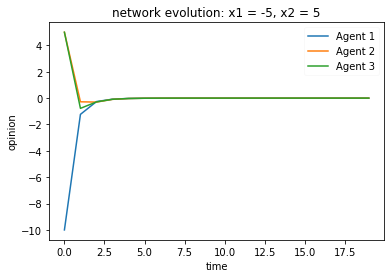

In [55]:
for i in range(3):
    plt.plot(range(20), [xs9[0][j][i].item() - 5 for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = -5, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

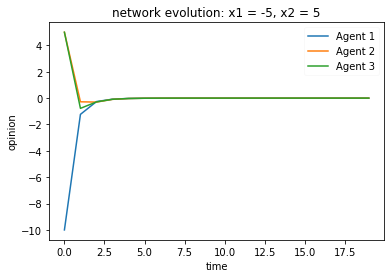

In [56]:
# double-checking that the chi = x - x_l works 
for i in range(3):
    plt.plot(range(20), [xs9[1][j][i].item() + 5 for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = -5, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

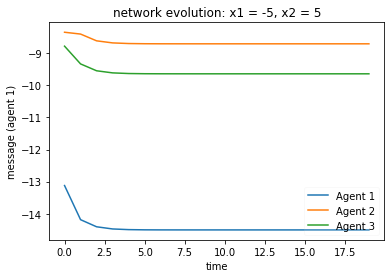

In [57]:
for i in range(3):
    plt.plot(range(20), [rs9[0][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 1)")
plt.title("network evolution: x1 = -5, x2 = 5")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

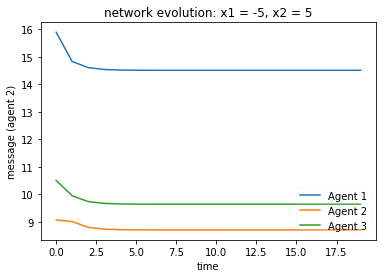

In [58]:
for i in range(3):
    plt.plot(range(20), [rs9[1][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 2)")
plt.title("network evolution: x1 = -5, x2 = 5")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

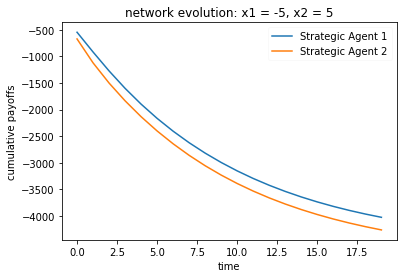

In [59]:
plt.plot(range(20), [payoffs9[0][j] for j in range(20)], label = f"Strategic Agent 1")
plt.plot(range(20), [payoffs9[1][j] for j in range(20)], label = f"Strategic Agent 2")
    
plt.xlabel("time")
plt.ylabel("cumulative payoffs")
plt.title("network evolution: x1 = -5, x2 = 5")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

What would happen in a perfectly opposed network?

In [60]:
A = np.array([ # note: ASYMMETRIC
    [0.6, 0.4],
    [0.2, 0.8]
])

X_0_1 = np.array([[-10.0, 10.0]], ndmin = 2).T
X_0 = [X_0_1 + 10, X_0_1 - 10]

delta = 0.9 # discount rate
n = 2 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [1 * np.identity(n), 1 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [-10, 10]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs10, rs10, payoffs10 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

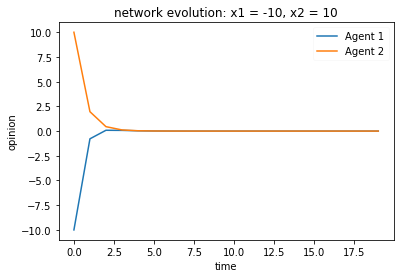

In [61]:
for i in range(2):
    plt.plot(range(20), [xs10[0][j][i].item() - 10 for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

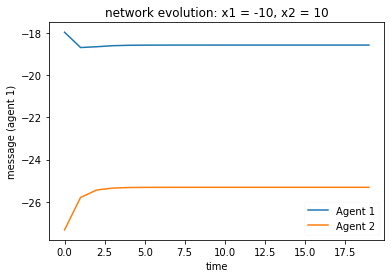

In [62]:
for i in range(2):
    plt.plot(range(20), [rs10[0][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 1)")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

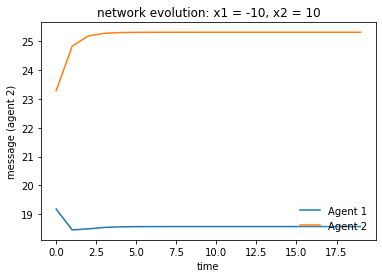

In [63]:
for i in range(2):
    plt.plot(range(20), [rs10[1][j][i].item() for j in range(20)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 2)")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

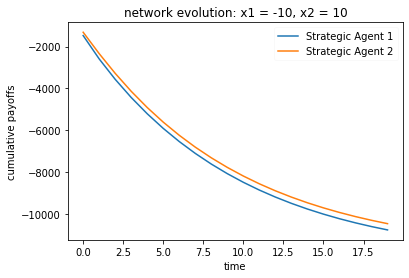

In [64]:
plt.plot(range(20), [payoffs10[0][j] for j in range(20)], label = f"Strategic Agent 1")
plt.plot(range(20), [payoffs10[1][j] for j in range(20)], label = f"Strategic Agent 2")
    
plt.xlabel("time")
plt.ylabel("cumulative payoffs")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

One step further: make the network symmetric again.

In [65]:
A = np.array([
    [0.6, 0.4],
    [0.4, 0.6]
])

X_0_1 = np.array([[-10.0, 10.0]], ndmin = 2).T
X_0 = [X_0_1 + 10, X_0_1 - 10]

delta = 0.9 # discount rate
n = 2 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [1 * np.identity(n), 1 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [-10, 10]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs11, rs11, payoffs11 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

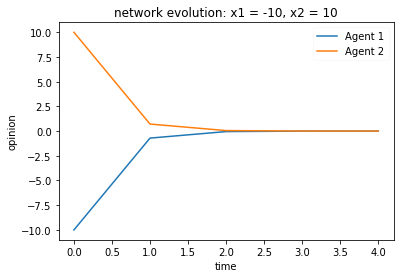

In [66]:
for i in range(2):
    plt.plot(range(5), [xs11[0][j][i].item() - 10 for j in range(5)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

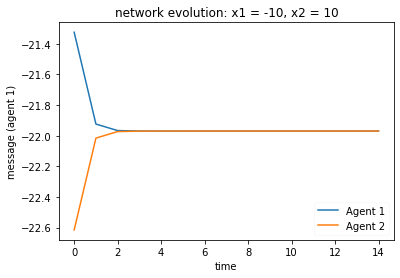

In [67]:
for i in range(2):
    plt.plot(range(15), [rs11[0][j][i].item() for j in range(15)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 1)")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

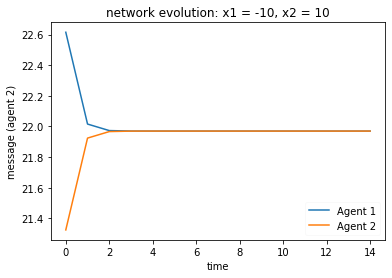

In [68]:
for i in range(2):
    plt.plot(range(15), [rs11[1][j][i].item() for j in range(15)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("message (agent 2)")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

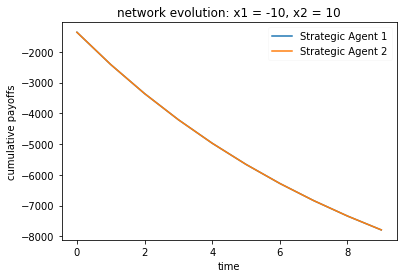

In [69]:
plt.plot(range(10), [payoffs11[0][j] for j in range(10)], label = f"Strategic Agent 1")
plt.plot(range(10), [payoffs11[1][j] for j in range(10)], label = f"Strategic Agent 2")
    
plt.xlabel("time")
plt.ylabel("cumulative payoffs")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()

Note that the interpretation is "naive agents with closer-to-agenda opinions do not need messages as intensive as naive agents further away".

Also note that if we reduce message cost, convergence is faster:

In [70]:
A = np.array([
    [0.6, 0.4],
    [0.4, 0.6]
])

X_0_1 = np.array([[-10.0, 10.0]], ndmin = 2).T
X_0 = [X_0_1 + 10, X_0_1 - 10]

delta = 0.9 # discount rate
n = 2 # number of naive agents
L = 2 # number of strategic agents
Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
R = [0.01 * np.identity(n), 0.01 * np.identity(n)] # message cost R = cI_n for some c under the new notation
B = [np.identity(n), np.identity(n)] # direct message broadcasting

x = [-10, 10]
r = [0, 0] # message cost minimality is centered around zero
c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
xs12, rs12, payoffs12 = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)

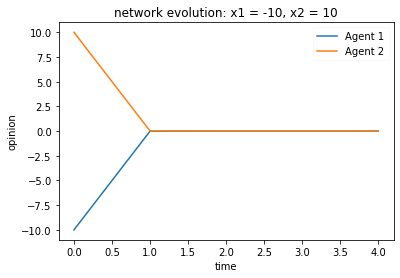

In [71]:
for i in range(2):
    plt.plot(range(5), [xs12[0][j][i].item() - 10 for j in range(5)], label = f"Agent {i+1}")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: x1 = -10, x2 = 10")
plt.legend(framealpha = 0.1, loc = "upper right")
plt.show()